In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.svm import SVR
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [37]:
df_train=pd.read_csv('/Users/maksimtrebusinin/Downloads/house-prices-advanced-regression-techniques/train.csv')
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

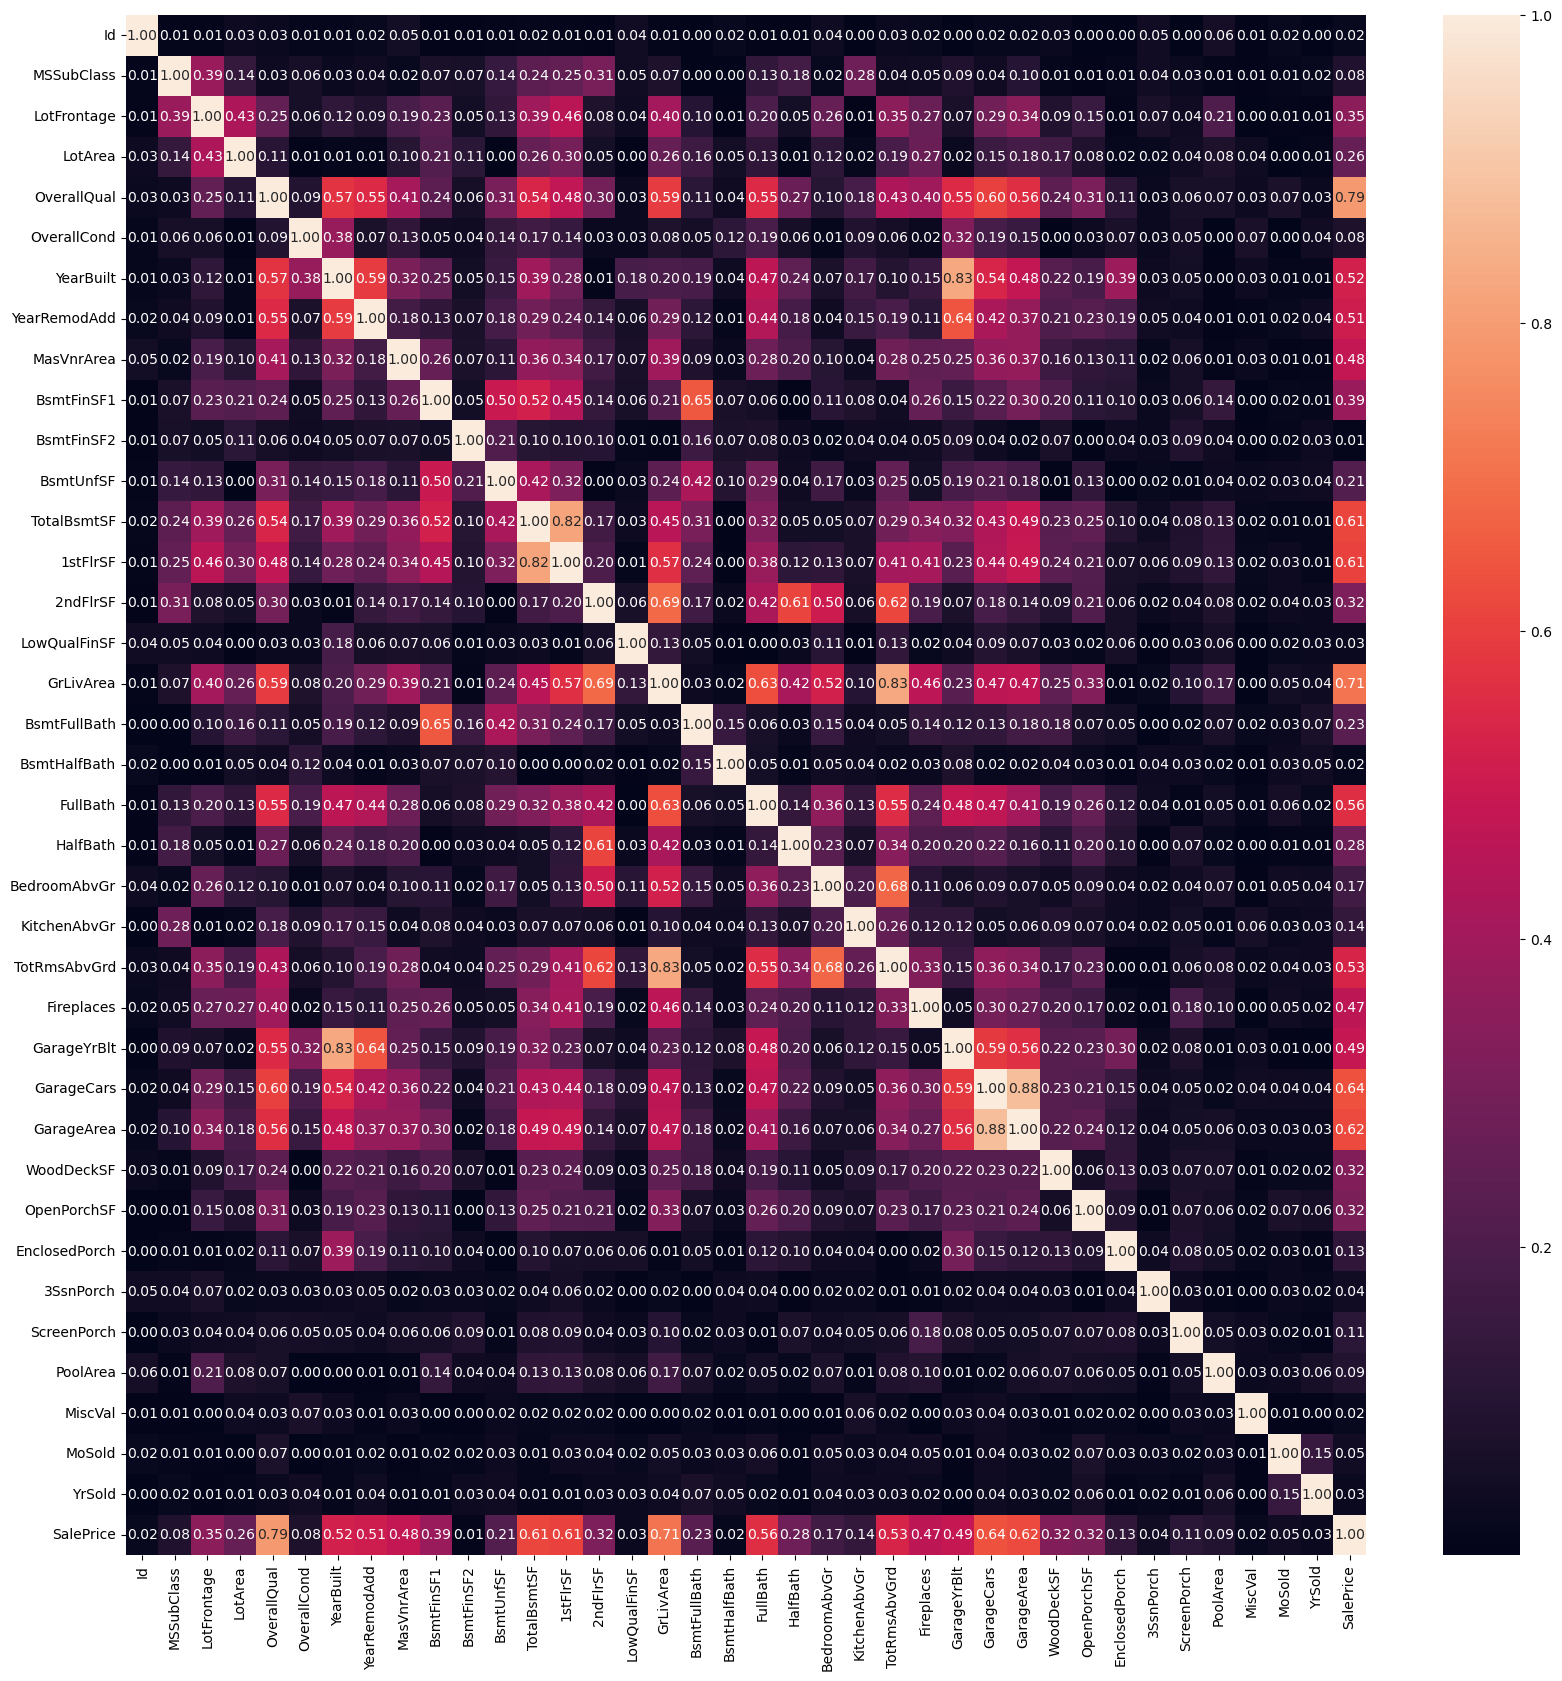

In [39]:
df_train_num=df_train.select_dtypes(['int','float'])
plt.figure(figsize=(20,20))
sns.heatmap(abs(df_train_num.corr()), annot=True, fmt='.2f')
plt.show()

In [40]:
lst_of_cols_to_drop=[]
for col in df_train.columns:
    if df_train[col].isna().sum()>1000:
        lst_of_cols_to_drop.append(col)
df_train.drop(lst_of_cols_to_drop, axis=1, inplace=True)

In [41]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [43]:
for col in df_train.columns:
    print(f'df_train[{col}] nunique values: {df_train[col].nunique()}')

df_train[Id] nunique values: 1460
df_train[MSSubClass] nunique values: 15
df_train[MSZoning] nunique values: 5
df_train[LotFrontage] nunique values: 110
df_train[LotArea] nunique values: 1073
df_train[Street] nunique values: 2
df_train[LotShape] nunique values: 4
df_train[LandContour] nunique values: 4
df_train[Utilities] nunique values: 2
df_train[LotConfig] nunique values: 5
df_train[LandSlope] nunique values: 3
df_train[Neighborhood] nunique values: 25
df_train[Condition1] nunique values: 9
df_train[Condition2] nunique values: 8
df_train[BldgType] nunique values: 5
df_train[HouseStyle] nunique values: 8
df_train[OverallQual] nunique values: 10
df_train[OverallCond] nunique values: 9
df_train[YearBuilt] nunique values: 112
df_train[YearRemodAdd] nunique values: 61
df_train[RoofStyle] nunique values: 6
df_train[RoofMatl] nunique values: 8
df_train[Exterior1st] nunique values: 15
df_train[Exterior2nd] nunique values: 16
df_train[MasVnrType] nunique values: 4
df_train[MasVnrArea] nuniqu

In [44]:
for col in df_train.select_dtypes('object').columns:
    print(f'df_train[{col}] nunique values: {df_train[col].nunique()}')

df_train[MSZoning] nunique values: 5
df_train[Street] nunique values: 2
df_train[LotShape] nunique values: 4
df_train[LandContour] nunique values: 4
df_train[Utilities] nunique values: 2
df_train[LotConfig] nunique values: 5
df_train[LandSlope] nunique values: 3
df_train[Neighborhood] nunique values: 25
df_train[Condition1] nunique values: 9
df_train[Condition2] nunique values: 8
df_train[BldgType] nunique values: 5
df_train[HouseStyle] nunique values: 8
df_train[RoofStyle] nunique values: 6
df_train[RoofMatl] nunique values: 8
df_train[Exterior1st] nunique values: 15
df_train[Exterior2nd] nunique values: 16
df_train[MasVnrType] nunique values: 4
df_train[ExterQual] nunique values: 4
df_train[ExterCond] nunique values: 5
df_train[Foundation] nunique values: 6
df_train[BsmtQual] nunique values: 4
df_train[BsmtCond] nunique values: 4
df_train[BsmtExposure] nunique values: 4
df_train[BsmtFinType1] nunique values: 6
df_train[BsmtFinType2] nunique values: 6
df_train[Heating] nunique values:

In [45]:
df_train_num=df_train.select_dtypes(['int', 'float'])
df_train_cat=df_train.select_dtypes('object')

In [46]:
df_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     1452 non-null   object
 17  ExterQual      1460 non-null   object
 18  ExterCond      1460 non-null

In [50]:
original=df_train_cat.copy()
mask=df_train_cat.isnull()
le=LabelEncoder()
for col in df_train_cat.columns:
    df_train_cat[col]=le.fit_transform(df_train_cat[col])
df_train_cat=df_train_cat.where(~mask, original)

In [51]:
df_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   int64 
 1   Street         1460 non-null   int64 
 2   LotShape       1460 non-null   int64 
 3   LandContour    1460 non-null   int64 
 4   Utilities      1460 non-null   int64 
 5   LotConfig      1460 non-null   int64 
 6   LandSlope      1460 non-null   int64 
 7   Neighborhood   1460 non-null   int64 
 8   Condition1     1460 non-null   int64 
 9   Condition2     1460 non-null   int64 
 10  BldgType       1460 non-null   int64 
 11  HouseStyle     1460 non-null   int64 
 12  RoofStyle      1460 non-null   int64 
 13  RoofMatl       1460 non-null   int64 
 14  Exterior1st    1460 non-null   int64 
 15  Exterior2nd    1460 non-null   int64 
 16  MasVnrType     1452 non-null   object
 17  ExterQual      1460 non-null   int64 
 18  ExterCond      1460 non-null

In [59]:
int_list=list()
for column in df_train_cat.columns:
    int_list.append(column)
for column in df_train.columns:
    if df_train[column].dtype=='int64':
        int_list.append(column)
print(f'Lengh of list: {len(int_list)}')
print(int_list)

Lengh of list: 74
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'Mo

In [60]:
df_train[df_train_cat.columns]=df_train_cat[df_train_cat.columns]

In [63]:
imputer=KNNImputer(n_neighbors=5, weights='uniform')
imp=imputer.fit_transform(df_train)
df_train_imp=pd.DataFrame(data=imp, columns=df_train.columns)

In [66]:
for col in int_list:
    df_train_imp[col]=df_train_imp[col].astype('int')

In [70]:
df_train_imp.duplicated().sum()

0

In [72]:
df_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int64  
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   int64  
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   int64  
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   int64  
 12  Condition1     1460 non-null   int64  
 13  Condition2     1460 non-null   int64  
 14  BldgType       1460 non-null   int64  
 15  HouseStyle     1460 non-null   int64  
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# Dimension reduction

In [73]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

X,y=df_train_imp.drop('SalePrice', axis=1), df_train_imp.SalePrice
model_lin_reg=LinearRegression()
model_lin_reg.fit(X,y)

coef=model_lin_reg.coef_
print(f'Coef of LinearRegression: {coef}')

Coef of LinearRegression: [-1.41531418e+00 -1.15511800e+02 -1.37786296e+03 -1.35705267e+02
  3.87387985e-01  2.79249036e+04 -1.06660490e+03  3.48697402e+03
 -4.73552453e+04 -9.93227628e+01  6.89856149e+03  3.73301944e+02
 -7.49217091e+02 -8.62550170e+03 -2.61759258e+03 -1.08959341e+03
  1.08917323e+04  4.58997795e+03  2.17205257e+02  4.46631596e+01
  2.15156505e+03  4.81162529e+03 -8.32031463e+02  2.58763685e+02
  4.40473193e+03  3.15053866e+01 -9.05105460e+03  3.20700144e+02
  8.73712483e+02 -8.36758718e+03  2.37961797e+03 -3.73616002e+03
 -9.42041655e+02  4.25539445e+00  6.77260151e+02  6.58884462e+00
 -2.36740688e+00  8.47683226e+00 -2.47633487e+03 -5.86879145e+02
 -3.40861639e+02 -3.03648046e+02  1.63974033e+01  1.79711290e+01
 -5.67762290e+00  2.86909093e+01  7.55006556e+03  1.17085780e+03
  4.53630962e+03  2.91256444e+02 -3.78035223e+03 -1.22896276e+04
 -8.54079679e+03  3.25054088e+03  3.89905917e+03  5.06603689e+03
 -1.95117787e+03  2.22891606e+02 -7.74298857e+01 -1.71467166e+03

In [84]:
for coef_num in range(len(coef)):
    print(f'{df_train_imp.iloc[:,coef_num].name} - {abs(coef[coef_num])}')

Id - 1.4153141821799011
MSSubClass - 115.51179971019249
MSZoning - 1377.862957133792
LotFrontage - 135.70526659927475
LotArea - 0.38738798523379714
Street - 27924.90357669942
LotShape - 1066.604896855793
LandContour - 3486.9740215650186
Utilities - 47355.24534187563
LotConfig - 99.32276277693427
LandSlope - 6898.561492376516
Neighborhood - 373.3019444688716
Condition1 - 749.2170911491098
Condition2 - 8625.50169778797
BldgType - 2617.592576957708
HouseStyle - 1089.593405755186
OverallQual - 10891.732334794426
OverallCond - 4589.977953184804
YearBuilt - 217.20525650734166
YearRemodAdd - 44.66315958838578
RoofStyle - 2151.565048739241
RoofMatl - 4811.625286112873
Exterior1st - 832.0314629913669
Exterior2nd - 258.76368488148745
MasVnrType - 4404.7319280791735
MasVnrArea - 31.50538657044649
ExterQual - 9051.054599595447
ExterCond - 320.70014379348095
Foundation - 873.7124829724908
BsmtQual - 8367.587181285038
BsmtCond - 2379.617970293475
BsmtExposure - 3736.1600164994034
BsmtFinType1 - 942.

In [87]:
print(np.mean(abs(coef)))

3061.652683771849


In [91]:
lst_name=[]
for num in range(len(coef)):
    if abs(coef[num])>3061:
        lst_name.append(df_train_imp.iloc[:,num].name)
print(lst_name)

['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition2', 'OverallQual', 'OverallCond', 'RoofMatl', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars']


In [97]:
X_for_rnf, y_for_rnf=df_train_imp[lst_name], df_train_imp.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X_for_rnf,y_for_rnf, test_size=0.2, random_state=42)

md_rnf_test=RandomForestRegressor()
md_rnf_test.fit(X_train,y_train)

y_pred=md_rnf_test.predict(X_test)

print(f'MAE is: {mean_absolute_error(y_test,y_pred)}')

MAE is: 22897.37703611837


In [112]:
print(f'R^2 is : {r2_score(y_test,y_pred)}')

R^2 is : 0.8590796695001703


In [101]:
model_lasso=Lasso(alpha=0.2)
model_lasso.fit(X,y)

coef_lasso=model_lasso.coef_
print(f'Coef of Lasso model: {coef_lasso}')

Coef of Lasso model: [-1.41571090e+00 -1.15529089e+02 -1.37759330e+03 -1.35713088e+02
  3.87361885e-01  2.78654156e+04 -1.06647143e+03  3.48619567e+03
 -4.70308133e+04 -9.90711474e+01  6.89349775e+03  3.73191330e+02
 -7.49123707e+02 -8.62204803e+03 -2.61734213e+03 -1.08972945e+03
  1.08922062e+04  4.58955404e+03  2.17227778e+02  4.46983965e+01
  2.15159698e+03  4.81201570e+03 -8.31833086e+02  2.58676683e+02
  4.40443519e+03  3.15008592e+01 -9.05018655e+03  3.20012976e+02
  8.72542848e+02 -8.36857416e+03  2.37888122e+03 -3.73626819e+03
 -9.42273382e+02  1.03290761e+01  6.76654190e+02  1.26566672e+01
  3.70372515e+00  2.40838257e+00 -2.47025599e+03 -5.86822652e+02
 -3.31626275e+02 -3.02306471e+02  4.00090875e+01  4.15884250e+01
  1.79383673e+01  5.08088824e+00  7.54643213e+03  1.16194931e+03
  4.53284220e+03  2.89533016e+02 -3.77951314e+03 -1.22796168e+04
 -8.54096217e+03  3.24922933e+03  3.89857721e+03  5.06564998e+03
 -1.95060827e+03  2.22445967e+02 -7.74233349e+01 -1.71394858e+03
  1.

In [111]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,y, test_size=0.2, random_state=42)
pca=PCA(n_components=15)

X_train_pc=pca.fit_transform(X_train_pca)
X_test_pc=pca.transform(X_test_pca)

md_rnf_test.fit(X_train_pc,y_train_pca)

y_pred_pca=md_rnf_test.predict(X_test_pc)
print(f'R^2 is: {r2_score(y_test_pca,y_pred_pca)}')

R^2 is: 0.7868891025354242


# Test data

In [115]:
df_test=pd.read_csv('/Users/maksimtrebusinin/Downloads/house-prices-advanced-regression-techniques/test.csv')
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [117]:
df_test.drop(lst_of_cols_to_drop, axis=1, inplace=True)

df_test_num=df_test.select_dtypes(['int','float'])
df_test_cat=df_test.select_dtypes('object')

original_t=df_test_cat.copy()
mask_t=df_test_cat.isnull()
le=LabelEncoder()
for col in df_test_cat.columns:
    df_test_cat[col]=le.fit_transform(df_test_cat[col])
df_test_cat=df_test_cat.where(~mask_t, original_t)

int_list_t=list()
for column in df_test_cat.columns:
    int_list_t.append(column)
for column in df_test.columns:
    if df_test[column].dtype=='int64':
        int_list_t.append(column)

df_test[df_test_cat.columns]=df_test_cat[df_test_cat.columns]
imputer=KNNImputer(n_neighbors=5, weights='uniform')
imp=imputer.fit_transform(df_test)
df_test_imp=pd.DataFrame(data=imp, columns=df_test.columns)

for col in int_list_t:
    df_test_imp[col]=df_test_imp[col].astype('int')

In [122]:
X_train,y_train=df_train_imp[lst_name], df_train_imp.SalePrice
X_test=df_test_imp[lst_name]

# Train and Prediction

In [142]:
def objective(trial):
    XGB={
        'tree_method':'hist'
    }

    params={
        'n_estimators':trial.suggest_int('n_estimators', 100,1000),
        'max_depth':trial.suggest_int('max_depth', 10, 200),
        'learning_rate':trial.suggest_float('learning_rate', 0.005, 0.01),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
    }

    model=XGBRegressor(**params, **XGB, n_jobs=-1)
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cross_val=cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    return np.mean(cross_val)

In [143]:
study=optuna.create_study(study_name='XGB-regressor', direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=60)

[I 2024-10-07 19:59:00,753] A new study created in memory with name: XGB-regressor
[I 2024-10-07 19:59:06,516] Trial 0 finished with value: 0.7899488435494183 and parameters: {'n_estimators': 389, 'max_depth': 194, 'learning_rate': 0.007254844039526011, 'min_child_weight': 2}. Best is trial 0 with value: 0.7899488435494183.
[I 2024-10-07 19:59:18,829] Trial 1 finished with value: 0.7922331777042041 and parameters: {'n_estimators': 760, 'max_depth': 70, 'learning_rate': 0.00715133143847218, 'min_child_weight': 2}. Best is trial 1 with value: 0.7922331777042041.
[I 2024-10-07 19:59:20,657] Trial 2 finished with value: 0.7628361267956965 and parameters: {'n_estimators': 190, 'max_depth': 145, 'learning_rate': 0.009205275210361514, 'min_child_weight': 4}. Best is trial 1 with value: 0.7922331777042041.
[I 2024-10-07 19:59:29,413] Trial 3 finished with value: 0.7920538444588672 and parameters: {'n_estimators': 678, 'max_depth': 145, 'learning_rate': 0.005295563795514957, 'min_child_weight':

In [144]:
samp=pd.read_csv('/Users/maksimtrebusinin/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv')
samp

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [147]:
xgb=XGBRegressor(**study.best_params)
xgb.fit(X_train,y_train)

prediction=xgb.predict(X_test)
samp['SalePrice']=prediction

In [149]:
samp.to_csv('pred1.csv', index=False)

In [152]:
def objective2(trial):
    params={
        'n_estimators':trial.suggest_int('n_estimators', 100,1000),
        'max_depth':trial.suggest_int('max_depth', 10, 200),
        'min_samples_split':trial.suggest_int('min_samples_split', 2, 10)
    }

    model=RandomForestRegressor(**params,n_jobs=-1)
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cross_val=cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    return np.mean(cross_val)

In [153]:
study=optuna.create_study(direction='maximize', study_name='rnf', sampler=optuna.samplers.TPESampler())
study.optimize(objective2, n_trials=50)

[I 2024-10-09 13:49:11,801] A new study created in memory with name: rnf
[I 2024-10-09 13:49:15,923] Trial 0 finished with value: 0.8119728601480853 and parameters: {'n_estimators': 933, 'max_depth': 120, 'min_samples_split': 9}. Best is trial 0 with value: 0.8119728601480853.
[I 2024-10-09 13:49:17,448] Trial 1 finished with value: 0.8140734762445876 and parameters: {'n_estimators': 324, 'max_depth': 179, 'min_samples_split': 2}. Best is trial 1 with value: 0.8140734762445876.
[I 2024-10-09 13:49:18,833] Trial 2 finished with value: 0.813663160097429 and parameters: {'n_estimators': 329, 'max_depth': 18, 'min_samples_split': 4}. Best is trial 1 with value: 0.8140734762445876.
[I 2024-10-09 13:49:21,876] Trial 3 finished with value: 0.8121669309598667 and parameters: {'n_estimators': 680, 'max_depth': 22, 'min_samples_split': 2}. Best is trial 1 with value: 0.8140734762445876.
[I 2024-10-09 13:49:22,960] Trial 4 finished with value: 0.8134080153152909 and parameters: {'n_estimators': 2

In [155]:
rnf=RandomForestRegressor(**study.best_params)
rnf.fit(X_train,y_train)
prediction2=rnf.predict(X_test)

samp1=pd.read_csv('/Users/maksimtrebusinin/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv')
samp1['SalePrice']=prediction2

samp1.to_csv('samp2.csv', index=False)